In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


from seaborn import load_dataset

from env import get_db_url

1. Acquire data from mall_customers.customers in mysql database.

In [2]:
url = get_db_url("mall_customers")

In [3]:
sql = "SELECT * FROM customers;"

In [4]:
df = pd.read_sql(sql, url)

In [5]:
def get_mall_data():
    url = get_db_url("mall_customers")
    sql = "SELECT * FROM customers;"
    df = pd.read_sql(sql, url)
    return df

In [6]:
mall = get_mall_data()

In [7]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
customer_id       200 non-null int64
gender            200 non-null object
age               200 non-null int64
annual_income     200 non-null int64
spending_score    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
mall.shape

(200, 5)

In [9]:
mall.isnull().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

2. Summarize data (include distributions and descriptive statistics).

In [10]:
mall.describe()

,customer_id,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


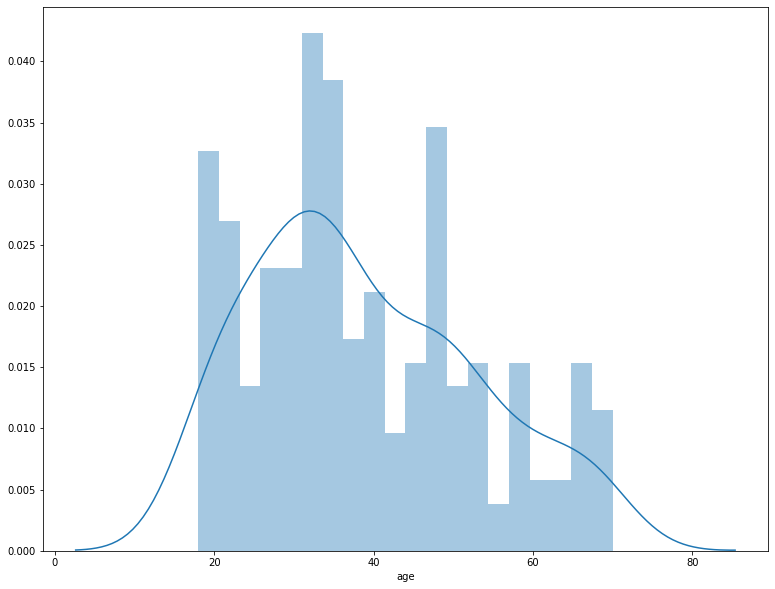

In [11]:
plt.figure(figsize=(13,10))
sns.distplot(mall.age, bins=20)

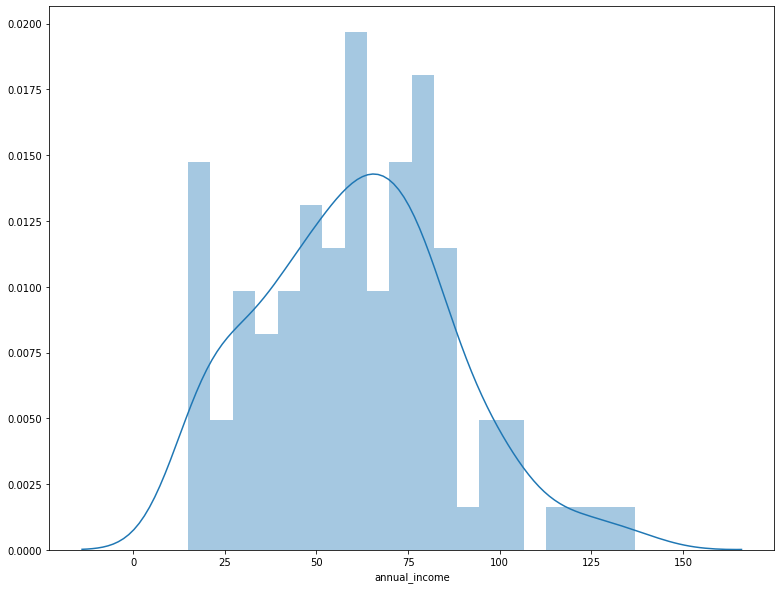

In [12]:
plt.figure(figsize=(13,10))
sns.distplot(mall.annual_income, bins=20)

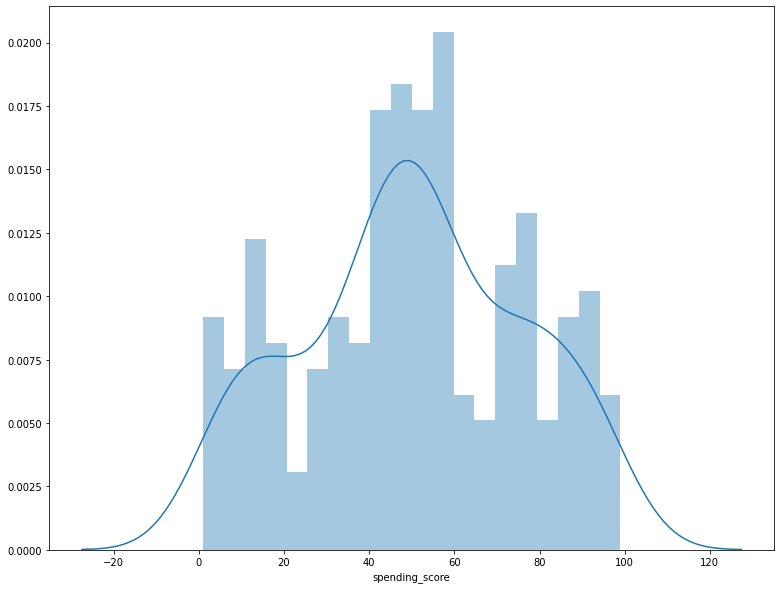

In [13]:
plt.figure(figsize=(13,10))
sns.distplot(mall.spending_score, bins=20)

3. Detect outliers using IQR.

In [14]:
def get_upper_outliers(s, k=1.5):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [15]:
def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

In [16]:
mall = add_upper_outlier_columns(mall, 1.5)

In [17]:
mall

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers
0,1,Male,19,15,39,0,0,0.00,0
1,2,Male,21,15,81,0,0,0.00,0
2,3,Female,20,16,6,0,0,0.00,0
3,4,Female,23,16,77,0,0,0.00,0
4,5,Female,31,17,40,0,0,0.00,0
...,...,...,...,...,...,...,...,...,...
195,196,Female,35,120,79,0,0,0.00,0
196,197,Female,45,126,28,0,0,0.00,0
197,198,Male,32,126,74,0,0,0.00,0
198,199,Male,32,137,18,0,0,4.25,0


4. Split data (train-test-split)

In [18]:
train, test = train_test_split(mall, train_size= .8, random_state=123)

5. Encode categorical columns using a one hot encoder.

In [19]:
ohe = OneHotEncoder()

In [20]:
ohe.fit(train[["gender"]])

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [21]:
m = ohe.transform(train[["gender"]]).todense()

In [22]:
cols = ["encoded_" + c for c in ohe.categories_[0]]

In [23]:
train = pd.concat([train, pd.DataFrame(m, columns =cols, index=train.index)], axis=1)

In [24]:
train.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,encoded_Female,encoded_Male
24,25,Female,54,28,14,0,0,0.0,0,1.0,0.0
150,151,Male,43,78,17,0,0,0.0,0,0.0,1.0
114,115,Female,18,65,48,0,0,0.0,0,1.0,0.0
33,34,Male,18,33,92,0,0,0.0,0,0.0,1.0
23,24,Male,31,25,73,0,0,0.0,0,0.0,1.0


In [25]:
ohe.categories_

[array(['Female', 'Male'], dtype=object)]

In [27]:
train.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers,age_outliers,annual_income_outliers,spending_score_outliers,encoded_Female,encoded_Male
24,25,Female,54,28,14,0,0,0.0,0,1.0,0.0
150,151,Male,43,78,17,0,0,0.0,0,0.0,1.0
114,115,Female,18,65,48,0,0,0.0,0,1.0,0.0
33,34,Male,18,33,92,0,0,0.0,0,0.0,1.0
23,24,Male,31,25,73,0,0,0.0,0,0.0,1.0
